In [1]:
def dimacs_cnf_files_parser():
    """
    DIMACS CNF format consists of:
        - Comment lines starting with 'c'
        - A problem line starting with 'p' that specifies the number of variables and clauses.
        - Clause lines containing space-separated integers, where positive integers represent 
          positive literals, negative integers represent negative literals, and each clause ends with 0.
          
    Parse a DIMACS CNF file and extract the number of variables, number of clauses, 
    and the list of clauses (each clause is a list of integers/literals).
    """    
    current_directory_files = os.listdir()
    dimacs_cnf_files_list = []
    
    for file_name in current_directory_files:
        if file_name.endswith('.cnf'):
            dimacs_cnf_files_list.append(file_name)
    
    if not dimacs_cnf_files_list:
        sys.exit("NO DIMACS CNF Files in this Directory...Exiting...")
    
    print("Available DIMACS CNF Files for Parsing: ")
    # print(*dimacs_cnf_files_list, sep = "\n")
    print(dimacs_cnf_files_list)
    dimacs_cnf_file = input("Enter DIMACS CNF File Name: ").strip()
    
    variables_number = 0
    clauses_number = 0
    cnf_clauses_list = []
    
    with open(dimacs_cnf_file, 'r') as f:
        for line in f:
            line = line.strip()
            
            # Skip empty lines and comment lines
            if not line or line.startswith('c'):
                continue
        
            # Parse the problem line
            if line.startswith('p'):
                problem_line = line.split()
                
                if len(problem_line) < 4 or problem_line[1] != 'cnf':
                    sys.exit(f"Warning: Invalid DIMACS header: {line}")
                
                try:
                    variables_number = int(problem_line[2])
                    clauses_number = int(problem_line[3])
                except ValueError:
                    sys.exit(f"Warning: Invalid numeric values in problem line: {line}")
                
                continue
        
            # Parse clause lines: split into literals and drop the terminating 0
            clause_line = line.split()
            
            # Each clause should end with a '0' as per DIMACS spec
            if clause_line[-1] != '0':
                sys.exit(f"Warning: Clause line missing terminating 0: {line}")
        
            clause_line_literals_list = [int(literal_symbol) for literal_symbol in clause_line[:-1]]
            cnf_clauses_list.append(clause_line_literals_list)
    
    # Verify clauses number
    if clauses_number != len(cnf_clauses_list):
        sys.exit(f"Warning: header declares {clauses_number} clauses, but parsed {len(cnf_clauses_list)}")
    
    # Verify variables number
    variables_list = []
    for clause in cnf_clauses_list:
        for literal in clause:
            variables_list.append(abs(literal))
    
    variables_set = set(variables_list) # convert to set to remove dupilcates
    if variables_number != len(variables_set):
        sys.exit(f"Warning: header declares {variables_number} variables, but parsed {len(variables_set)}")
        
    
    # Generate the boolean expression of the SAT from the CNF clauses list
    clause_formula = []
    for clause in cnf_clauses_list:
        clause_literals = []
        for literal in clause:
            literal_index = abs(literal)  # Convert to 0-based indexing?
            literal_name = f"x{literal_index}"
            
            if literal < 0:
                clause_literals.append(f"~{literal_name}")
            else:
                clause_literals.append(literal_name)
        
        # Join literals with OR operators
        literals_disjunction = " | ".join(clause_literals)
        clause_formula.append(f"({literals_disjunction})")
    
    # Join clauses with AND operators
    cnf_fromula = " & ".join(clause_formula)
    
    
    print(f"Variables = {variables_number}, Clauses = {clauses_number}")
    print(F"Clauses List: {cnf_clauses_list}")
    print(f"SAT Formula: {cnf_fromula}")
    
    for i, clause in enumerate(cnf_clauses_list, 1):
        print(f"Clause {i}: {clause} --> {cnf_fromula.split('&')[i - 1]}")
    
    return variables_number, clauses_number, cnf_clauses_list


In [2]:
# Run quantum counting to estimate the number of SATISFYING solutions 

def quantum_counting(variables_number, clauses_number, cnf_clauses_list):

    def controlled_grover_operator(power):
        
        # Allocate registers
        literals_reg    = QuantumRegister(variables_number, name = 'X')  # Literal Qubits
        clauses_reg = QuantumRegister(clauses_number, name = 'Clause')  # Clause Satisfaction qubits
        ancillary_reg = QuantumRegister(1, name = 'Workspace') # SAT Satisfaction Qubit
        qc = QuantumCircuit(literals_reg, clauses_reg, ancillary_reg)

        # Controlled-UˆP operations
        for i in range(power):
            # Loop through clauses to build the SAT Oracle
            for index, clause in enumerate(cnf_clauses_list):
                clause_satisfaction_qubit = clauses_reg[index]
                clause_literals_as_control_list = []
        
                # if literal is positive, invert its qubit - De Morgan's laws: (i) (A ∪ B)' = A' ∩ B' and (ii) (A ∩ B)' = A' ∪ B'
                for literal in clause:
                    literal_qubit_index = literals_reg[abs(literal) - 1] # convert to 0-based indexing
                    if literal > 0:
                        qc.x(literal_qubit_index )
                    clause_literals_as_control_list.append(literal_qubit_index)
        
                # Multi-controlled X onto the clause satisfaction qubit - De Morgan's laws: (i) (A ∪ B)' = A' ∩ B' and (ii) (A ∩ B)' = A' ∪ B'
                qc.x(clause_satisfaction_qubit) # set clause satisfaction qubit to 1
                
                # 1 xor conjunction of literals complements = disjunction of original literals (The Original CNF)
                qc.mcx(clause_literals_as_control_list, clause_satisfaction_qubit) 
        
                # Uncompute the negations to restore literal qubit
                for literal in clause:
                    if literal > 0:
                        qc.x(literals_reg[abs(literal) - 1])
                
                # qc.barrier()
        
            # qc.barrier()
            # calculating and marking the SAT solution on the CNF satisfaction qubit
            clauses_as_control_list = [c for c in clauses_reg]
            cnf_satisfaction_qubit = ancillary_reg
            qc.mcx(clauses_as_control_list, cnf_satisfaction_qubit)
            # qc.barrier()

            # Uncompute the previous operations to restore literal qubits
            cnf_clauses_list_reversed = cnf_clauses_list[::-1]
            reversed_clauses_index = len(cnf_clauses_list) - 1
            for index, clause in enumerate(cnf_clauses_list_reversed):
                clause_satisfaction_qubit = clauses_reg[reversed_clauses_index - index]
                clause_literals_as_control_list = []
        
                # if literal is positive, invert its qubit
                for literal in clause:
                    literal_qubit_index = literals_reg[abs(literal) - 1]
                    if literal > 0:
                        qc.x(literal_qubit_index)
                    clause_literals_as_control_list.append(literal_qubit_index)
        
                # Multi-controlled X onto the clause qubit
                qc.mcx(clause_literals_as_control_list, clause_satisfaction_qubit)
                qc.x(clause_satisfaction_qubit)
        
                # Uncompute the negations to restore literal qubit
                for literal in clause:
                    if literal > 0:
                        qc.x(literals_reg[abs(literal) - 1])
                # qc.barrier()
        
            # Grover Diffusion Operator
            qc.h([v for v in literals_reg])
            qc.x([v for v in literals_reg])
            qc.h(literals_reg[-1])
            if variables_number == 1:
                qc.x(literals_reg)
            else:
                qc.mcx(literals_reg[:-1], literals_reg[-1])
            qc.h(literals_reg[-1])
            # qc.barrier()
            qc.x([v for v in literals_reg])
            qc.h([v for v in literals_reg])
            # qc.barrier()

        # display(qc.draw('mpl', fold = -1))
        U = qc.to_gate()
        U.name = "U ^ {0}".format(power)
        controlled_U = U.control() # Controlled-UˆP operations
        return controlled_U
    
    # Set Phase and Controlled-U^P Registers Number
    n_work = variables_number + clauses_number + 1 # U^P 
    n_control = variables_number * 2 + 1       # Phase  
    
    phase_reg = QuantumRegister(n_control, name = "Phase")
    literals_reg = QuantumRegister(variables_number, name = "X")
    clauses_reg = QuantumRegister(clauses_number, name = "Clause")
    ancillary_reg = QuantumRegister(1, name = "Workspace")
    classical_reg = ClassicalRegister(n_control, name = "Classical")
    qc = QuantumCircuit(phase_reg, literals_reg, clauses_reg, ancillary_reg, classical_reg)
    
    # initialization
    qc.x(ancillary_reg)
    qc.barrier()
    qc.h(phase_reg)
    qc.h(literals_reg)
    qc.h(ancillary_reg)
    
    # Apply Controlled U^P
    for k in range(n_control):
        qc.append(controlled_grover_operator(2 ** k), [k] + [i + n_control for i in range(n_work)])
    
    # Apply Inverse QFT on Phase Register
    qc.append(QFTGate(n_control).inverse(), phase_reg)
    
    qc.measure(phase_reg, classical_reg)
    simulator = AerSimulator()
    qc_transpilation = transpile(qc, simulator)
    qc_simulation = simulator.run(qc_transpilation)
    qc_results = qc_simulation.result().get_counts()
    
    display(qc.draw('mpl', fold = -1))
    display(plot_histogram(qc_results))

    phase_bitstring , count = max(qc_results.items(), key = lambda kv: kv[1])
    phase = int(phase_bitstring , 2)
    theta = math.pi * ((phase / (2 ** n_control)) - (1 / 2))
    N = 2 ** variables_number
    M =  round(N * (math.sin(theta) ** 2))
    print(f"Estimated Solutions Number (M) = {M}")
    
    return M


In [3]:
# Use partial diffuison operator to solve the SAT problem

def pd_sat_solver(variables_number, clauses_number, cnf_clauses_list, estimated_solutions_number):

    if estimated_solutions_number == 0:
        return "UNSATISFIABLE"

    # Allocate registers
    literals_reg = QuantumRegister(variables_number, name = "X") # Literal Qubits
    clauses_reg = QuantumRegister(clauses_number, name = "Clause") # Clause Satisfaction qubits
    ancillary_reg = QuantumRegister(1, name = "Workspace") # SAT Satisfaction Qubit
    classical_reg = ClassicalRegister(variables_number, name = "Classical")
    qc = QuantumCircuit(literals_reg, clauses_reg, ancillary_reg, classical_reg)
    matrixU = [[-1 , 0], [0, 1]]
    matrixV = [[-1, 0], [0, -1]]
    cu_gate = UnitaryGate(matrixU, label = "U").control(variables_number)
    v_gate = UnitaryGate(matrixV, label = "V")
    
    M = estimated_solutions_number
    N = 2 ** variables_number
    print(f"Search Space (N) = {N}")

    iterations_number = math.floor(((math.pi / 4) * (math.sqrt(N / M))))
    print(f'Iterations Number = {iterations_number}')
    
    # initialization
    qc.h(literals_reg)
    qc.barrier()

    for i in range(iterations_number):
        # Loop through clauses to build the SAT Oracle
        for index, clause in enumerate(cnf_clauses_list):
            clause_satisfaction_qubit = clauses_reg[index]
            clause_literals_as_control_list = []
    
            # if literal is positive, invert its qubit - De Morgan's laws: (i) (A ∪ B)' = A' ∩ B' and (ii) (A ∩ B)' = A' ∪ B'
            for literal in clause:
                literal_qubit_index = literals_reg[abs(literal) - 1] # convert to 0-based indexing
                if literal > 0:
                    qc.x(literal_qubit_index )
                clause_literals_as_control_list.append(literal_qubit_index)
    
            # Multi-controlled X onto the clause satisfaction qubit - De Morgan's laws: (i) (A ∪ B)' = A' ∩ B' and (ii) (A ∩ B)' = A' ∪ B'
            qc.x(clause_satisfaction_qubit) # set clause satisfaction qubit to 1
            
            # 1 xor conjunction of literals complements = disjunction of original literals (The Original CNF)
            qc.mcx(clause_literals_as_control_list, clause_satisfaction_qubit) 
    
            # Uncompute the negations to restore literal qubit
            for literal in clause:
                if literal > 0:
                    qc.x(literals_reg[abs(literal) - 1])
            
            qc.barrier()
    
        # calculating and marking the SAT solution on the CNF satisfaction qubit
        clauses_as_control_list = [c for c in clauses_reg]
        cnf_satisfaction_qubit = ancillary_reg
        qc.mcx(clauses_as_control_list, cnf_satisfaction_qubit)
        qc.barrier()
    
        # Uncompute the previous operations to restore literal qubits
        cnf_clauses_list_reversed = cnf_clauses_list[::-1]
        reversed_clauses_index = len(cnf_clauses_list) - 1
        for index, clause in enumerate(cnf_clauses_list_reversed):
            clause_satisfaction_qubit = clauses_reg[reversed_clauses_index - index]
            clause_literals_as_control_list = []
    
            # if literal is positive, invert its qubit
            for literal in clause:
                literal_qubit_index = literals_reg[abs(literal) - 1]
                if literal > 0:
                    qc.x(literal_qubit_index)
                clause_literals_as_control_list.append(literal_qubit_index)
    
            # Multi-controlled X onto the clause qubit
            qc.mcx(clause_literals_as_control_list, clause_satisfaction_qubit)
            qc.x(clause_satisfaction_qubit)
    
            # Uncompute the negations to restore literal qubit
            for literal in clause:
                if literal > 0:
                    qc.x(literals_reg[abs(literal) - 1])
            qc.barrier()
    
        # Partial Diffusion Operator
        qc.h([v for v in literals_reg])
        qc.x([v for v in literals_reg])
        qc.append(cu_gate, [*literals_reg, ancillary_reg])
        qc.append(v_gate, ancillary_reg)
        qc.x([v for v in literals_reg])
        qc.h([v for v in literals_reg])
        qc.barrier()

    
    qc.measure(literals_reg, classical_reg)
    simulator = AerSimulator()
    qc_transpilation = transpile(qc, simulator)
    qc_simulation = simulator.run(qc_transpilation)
    qc_results = qc_simulation.result().get_counts()
    
    display(qc.draw('mpl', fold = -1))
    display(plot_histogram(qc_results))

    # Arrange results in descending order
    qc_results_sorted = dict(sorted(qc_results.items(),  key = lambda kv: kv[1], reverse = True)) 

    # Pick M number of results from the arranged results dictionary according to the Estimated Solutions Number (M)
    solutions = dict(itertools.islice(qc_results_sorted.items(), estimated_solutions_number)) 

    # Measurement Results Interpretation
    for key, value in solutions.items():
        solution_clause = list(key)
        solution_clause.reverse() # from Little Endian to Big Endian
        solution_clause_int_list = [int(x) for x in solution_clause]
        
        clause_literals = []
        dimacs_cnf_clauses_list = []
        for i, literal in enumerate(solution_clause_int_list, 1):
            literal_name = f"x{i}"
            if literal == 0:
                clause_literals.append(f"~{literal_name}") # express clause as literals
                dimacs_cnf_clauses_list.append(- i) # express clause as integers
            else:
                clause_literals.append(literal_name)
                dimacs_cnf_clauses_list.append(i)
        
        # Join literals with OR operators
        literals_disjunction = " | ".join(clause_literals)
    
        print(f"\n{dimacs_cnf_clauses_list} --> ({literals_disjunction}) --> {int((value / 1024) * 100)}%")


Available DIMACS CNF Files for Parsing: 
['2vsat.cnf', '3v3c.cnf', '3v5c.cnf', '3vsat.cnf', '4v3c.cnf', '4v6c.cnf', '4v7c.cnf', '5v4c.cnf', 'u1v2c.cnf', 'u3v6c.cnf', 'u4v8c.cnf']


Enter DIMACS CNF File Name:  3v5c.cnf


Variables = 3, Clauses = 5
Clauses List: [[-1, -2, -3], [1, -2, 3], [1, 2, -3], [1, -2, -3], [-1, 2, 3]]
SAT Formula: (~x1 | ~x2 | ~x3) & (x1 | ~x2 | x3) & (x1 | x2 | ~x3) & (x1 | ~x2 | ~x3) & (~x1 | x2 | x3)
Clause 1: [-1, -2, -3] --> (~x1 | ~x2 | ~x3) 
Clause 2: [1, -2, 3] -->  (x1 | ~x2 | x3) 
Clause 3: [1, 2, -3] -->  (x1 | x2 | ~x3) 
Clause 4: [1, -2, -3] -->  (x1 | ~x2 | ~x3) 
Clause 5: [-1, 2, 3] -->  (~x1 | x2 | x3)


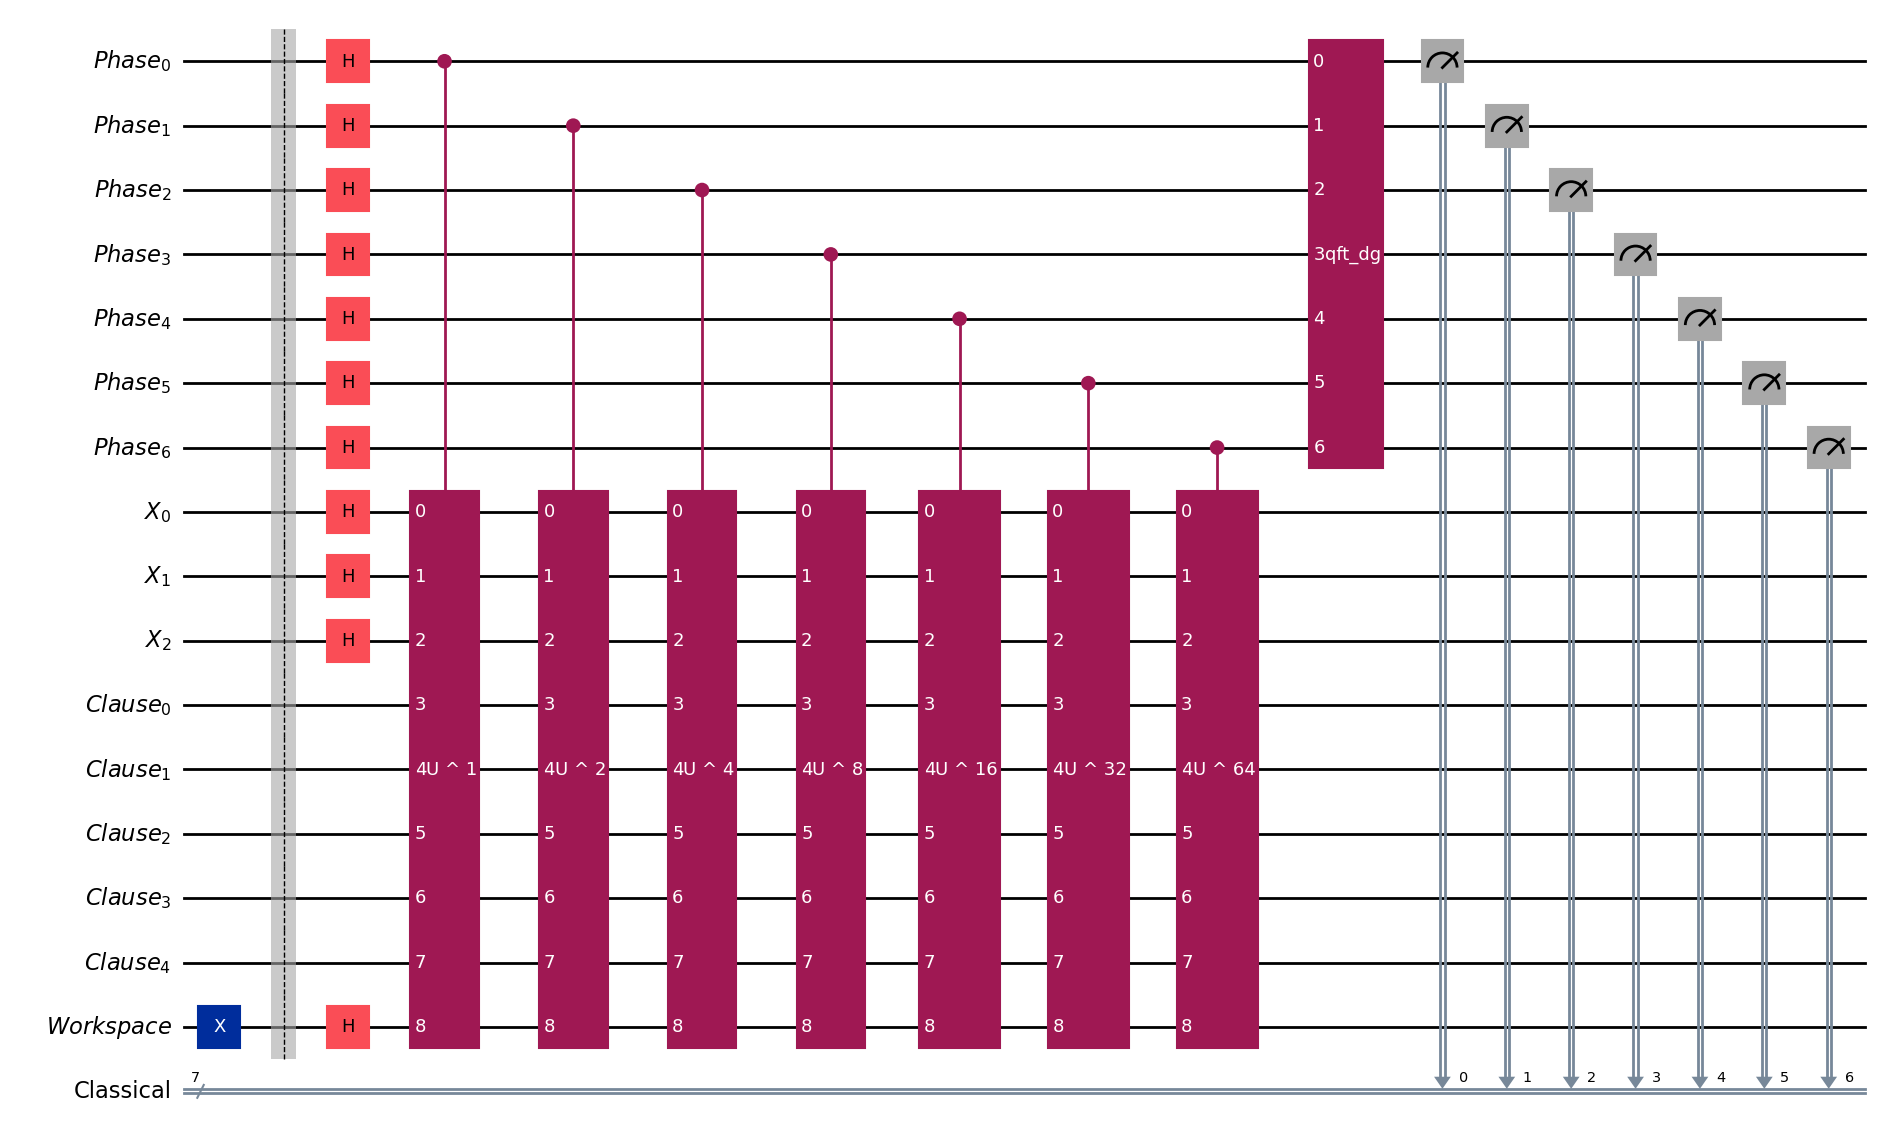

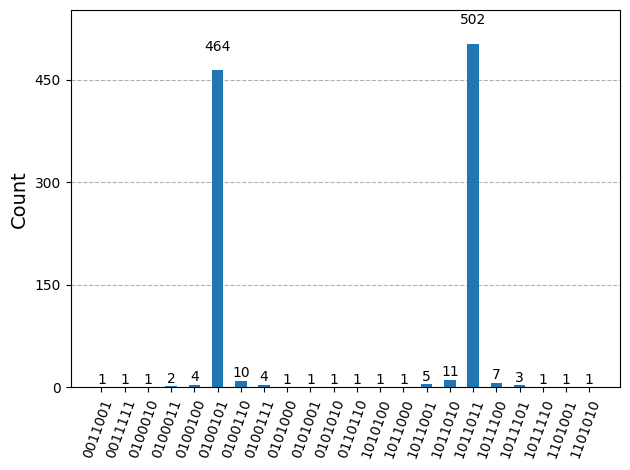

Estimated Solutions Number (M) = 3
Search Space (N) = 8
Iterations Number = 1


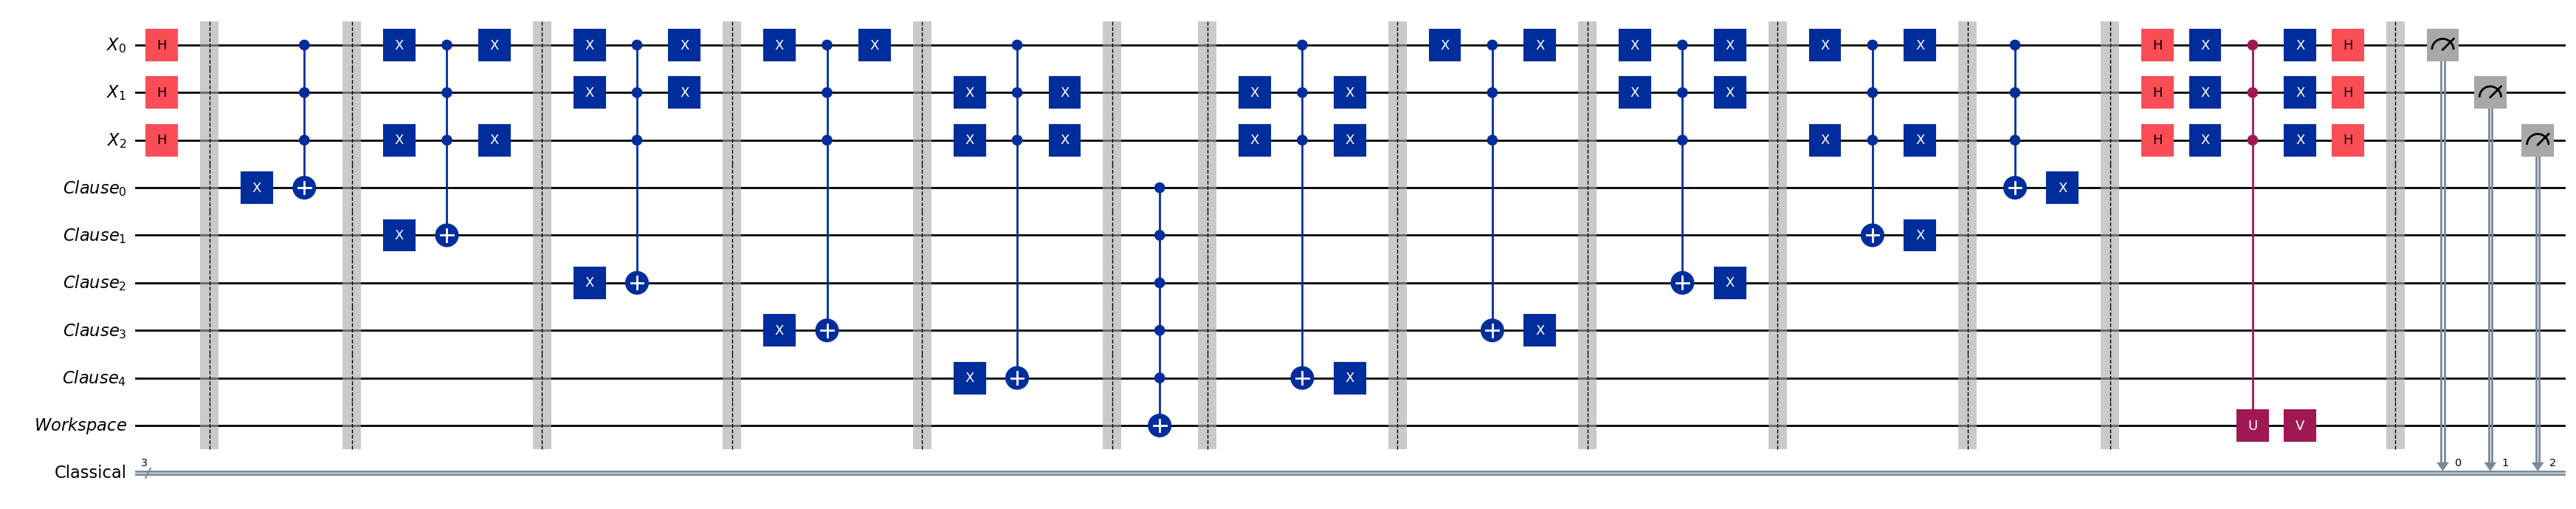

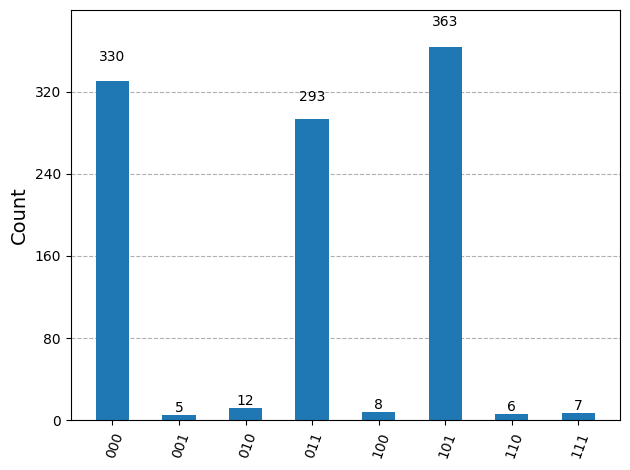


[1, -2, 3] --> (x1 | ~x2 | x3) --> 35%

[-1, -2, -3] --> (~x1 | ~x2 | ~x3) --> 32%

[1, 2, -3] --> (x1 | x2 | ~x3) --> 28%


In [4]:
import os, sys, math, itertools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import QFTGate, UnitaryGate
from qiskit_aer import AerSimulator
from IPython.display import display
from qiskit.visualization import plot_histogram

# 1. Parse DIMACS CNF files
variables_number, clauses_number, cnf_clauses_list = dimacs_cnf_files_parser()

# 2. Run quantum counting to estimate # of solutions
estimated_solutions_number = quantum_counting(variables_number, clauses_number, cnf_clauses_list)

# 3. If solutions exist, run the PD-based SAT solver
pd_sat_solver(variables_number, clauses_number, cnf_clauses_list, estimated_solutions_number)